In [ ]:
!unzip /content/drive/MyDrive/vmp_ml_project/final_dataset.zip

In [ ]:
TEST_DIR = '/content/content/final_dataset/test/'
TRAIN_DIR = '/content/content/final_dataset/train/'
VALID_DIR = '/content/content/final_dataset/val/'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [ ]:
train_tfms = T.Compose([T.ToTensor()])

valid_tfms = T.Compose([T.ToTensor()])

test_tfms = T.Compose([T.ToTensor()])

In [ ]:
train_ds = ImageFolder(TRAIN_DIR, train_tfms)
val_ds = ImageFolder(VALID_DIR, valid_tfms)
test_ds = ImageFolder(TEST_DIR, test_tfms)

In [ ]:
train_ds

Dataset ImageFolder
    Number of datapoints: 52391
    Root location: /content/content/final_dataset/train/
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
len(train_ds),len(val_ds)

(52391, 5034)

In [ ]:
batch_size = 32

In [ ]:
train_loader = DataLoader(train_ds, batch_size = batch_size,shuffle = True)
val_loader = DataLoader(val_ds, batch_size = batch_size,shuffle = True)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
      
    def train_accuracy(self,batch):
      images,labels = batch
      out = self(images)
      train_acc = accuracy(out,labels)
      return train_acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)              
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)    
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() 
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() 
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'],result['train_acc'], result['val_loss'], result['val_acc']))

In [ ]:
class Net(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(3,32,(3,3),padding = "same")
    self.conv2 = nn.Conv2d(32,64,(3,3),padding = "same")
    self.conv3 = nn.Conv2d(64,128,(3,3),padding = "same")
    self.conv4= nn.Conv2d(128,256,(3,3),padding = "same")
    self.conv5 = nn.Conv2d(256,256,(3,3),padding = "same")
    self.conv6 = nn.Conv2d(256,512,(3,3),padding = "same")
    self.conv7 = nn.Conv2d(512,1024,(3,3),padding = "same")
    self.conv8 = nn.Conv2d(1024,1024,(3,3),padding = "same")

    
    self.fc1 = nn.Linear(1024,1024)
    self.fc2 = nn.Linear(1024,1024)
    self.fc3 = nn.Linear(1024,400)

  def forward(self,x):
    x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
    x = F.max_pool2d(F.relu(self.conv4(x)),(2,2))
    x = F.max_pool2d(F.relu(self.conv5(x)),(2,2))
    x = F.relu(self.conv6(x))
    x = F.max_pool2d(F.relu(self.conv7(x)),(2,2))
    x = F.max_pool2d(F.relu(self.conv8(x)),(2,2))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
net = Net()

In [ ]:
net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv8): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=400, bias=True)
)

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    train_acc = 0.0
    
    optimizer = opt_func(model.parameters(), max_lr)
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_acc = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            train_acc.append(model.train_accuracy(batch))
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        result['train_acc'] = torch.stack(train_acc).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(Net(), device)

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.0025712025817483664, 'val_loss': 5.991680145263672}]

In [ ]:
epochs = 50
max_lr = 0.0001
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, opt_func=opt_func)

  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.7823, train_acc: 0.0081, val_loss: 5.3894, val_acc: 0.0166


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.8714, train_acc: 0.0528, val_loss: 4.5170, val_acc: 0.0759


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.8880, train_acc: 0.1649, val_loss: 3.5319, val_acc: 0.2145


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.1624, train_acc: 0.2955, val_loss: 2.9905, val_acc: 0.3107


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.6424, train_acc: 0.4012, val_loss: 2.5782, val_acc: 0.3934


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.2358, train_acc: 0.4883, val_loss: 2.2888, val_acc: 0.4562


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.9160, train_acc: 0.5571, val_loss: 2.0873, val_acc: 0.5043


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.6449, train_acc: 0.6172, val_loss: 1.9917, val_acc: 0.5300


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.4184, train_acc: 0.6712, val_loss: 1.8468, val_acc: 0.5564


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.2201, train_acc: 0.7182, val_loss: 1.8178, val_acc: 0.5712


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.0354, train_acc: 0.7649, val_loss: 1.7022, val_acc: 0.6023


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.8772, train_acc: 0.8037, val_loss: 1.7609, val_acc: 0.6064


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.7323, train_acc: 0.8424, val_loss: 1.7885, val_acc: 0.6196


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5972, train_acc: 0.8792, val_loss: 1.7562, val_acc: 0.6303


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4851, train_acc: 0.9078, val_loss: 2.0588, val_acc: 0.6095


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.3915, train_acc: 0.9348, val_loss: 1.8871, val_acc: 0.6383


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.3241, train_acc: 0.9513, val_loss: 2.0653, val_acc: 0.6457


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.2610, train_acc: 0.9675, val_loss: 2.0744, val_acc: 0.6494


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.2195, train_acc: 0.9768, val_loss: 2.2108, val_acc: 0.6435


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.1857, train_acc: 0.9839, val_loss: 2.3985, val_acc: 0.6473


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.1673, train_acc: 0.9876, val_loss: 2.3580, val_acc: 0.6436


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.1503, train_acc: 0.9905, val_loss: 2.3954, val_acc: 0.6441


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.1339, train_acc: 0.9924, val_loss: 2.4874, val_acc: 0.6511


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.1251, train_acc: 0.9947, val_loss: 2.4674, val_acc: 0.6547


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.1126, train_acc: 0.9951, val_loss: 2.6480, val_acc: 0.6422


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.1058, train_acc: 0.9960, val_loss: 2.7571, val_acc: 0.6539


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.1046, train_acc: 0.9964, val_loss: 2.7675, val_acc: 0.6307


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.0987, train_acc: 0.9969, val_loss: 2.6112, val_acc: 0.6566


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.0907, train_acc: 0.9976, val_loss: 2.8808, val_acc: 0.6403


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.0848, train_acc: 0.9977, val_loss: 2.7229, val_acc: 0.6517


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.0816, train_acc: 0.9979, val_loss: 2.6536, val_acc: 0.6706


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.0832, train_acc: 0.9978, val_loss: 2.6726, val_acc: 0.6620


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.0743, train_acc: 0.9980, val_loss: 2.7985, val_acc: 0.6670


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.0739, train_acc: 0.9981, val_loss: 2.9574, val_acc: 0.6473


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.0674, train_acc: 0.9986, val_loss: 2.6630, val_acc: 0.6599


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.0685, train_acc: 0.9987, val_loss: 2.6993, val_acc: 0.6570


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.0633, train_acc: 0.9986, val_loss: 2.7974, val_acc: 0.6655


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.0646, train_acc: 0.9988, val_loss: 2.7527, val_acc: 0.6625


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.0628, train_acc: 0.9990, val_loss: 2.8183, val_acc: 0.6610


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.0593, train_acc: 0.9990, val_loss: 2.7699, val_acc: 0.6631


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.0559, train_acc: 0.9993, val_loss: 2.7271, val_acc: 0.6587


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.0511, train_acc: 0.9992, val_loss: 3.5327, val_acc: 0.6300


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.0540, train_acc: 0.9991, val_loss: 2.7462, val_acc: 0.6712


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.0555, train_acc: 0.9992, val_loss: 2.9953, val_acc: 0.6595


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.0502, train_acc: 0.9994, val_loss: 3.0141, val_acc: 0.6695


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.0508, train_acc: 0.9993, val_loss: 3.0183, val_acc: 0.6739


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.0466, train_acc: 0.9994, val_loss: 3.1038, val_acc: 0.6582


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.0477, train_acc: 0.9993, val_loss: 2.8413, val_acc: 0.6735


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.0466, train_acc: 0.9994, val_loss: 2.8109, val_acc: 0.6669


  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.0464, train_acc: 0.9994, val_loss: 2.8982, val_acc: 0.6653
CPU times: user 3h 3min 42s, sys: 4min 12s, total: 3h 7min 55s
Wall time: 3h 7min 26s


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. no. of epochs')

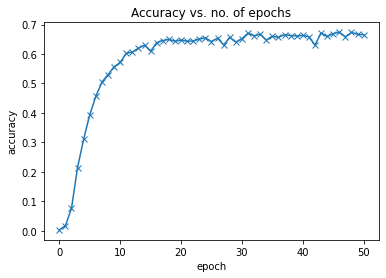

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss') 
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. no. of epochs')

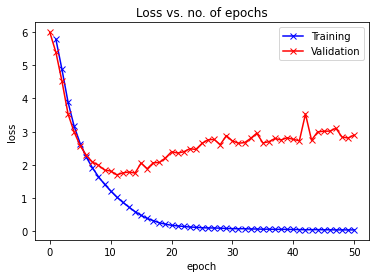

In [ ]:
plot_losses(history)